In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import calendar
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import all csvs
test = pd.read_csv('competitive-data-science-predict-future-sales/test.csv')
sales = pd.read_csv('competitive-data-science-predict-future-sales/sales_train.csv')
shops = pd.read_csv('competitive-data-science-predict-future-sales/shops.csv')
items = pd.read_csv('competitive-data-science-predict-future-sales/items.csv')
item_categories = pd.read_csv('competitive-data-science-predict-future-sales/item_categories.csv')

# Perform Data Exporation

In [3]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [4]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [6]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


# Inspect Data & Find Anomolies

<AxesSubplot:>

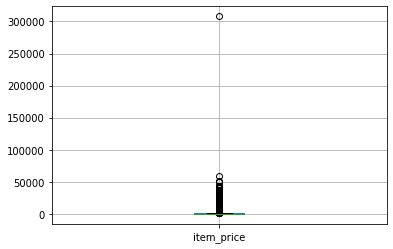

In [8]:
# This box plot shows distinct outliers (e.g., > 10000, < 0)
sales.boxplot(column=['item_price'])

In [9]:
# correct the anomolies
lessthanzero = sales[sales.item_price <= 0]
lessthanzero.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [10]:
sales_train = sales[(sales.item_price > 0) & (sales.item_price < 300000)]

<AxesSubplot:>

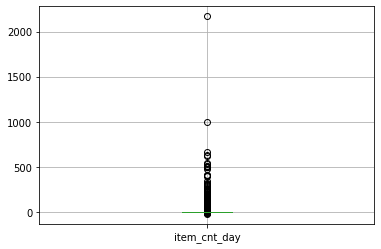

In [11]:
# This box plot shows distinct outliers (e.g., > 750, < 0) - where < 0 may be thought of as returns/refunds
sales_train.boxplot(column=['item_cnt_day'])

In [12]:
sales_train = sales_train[sales_train.item_cnt_day < 750]

<AxesSubplot:>

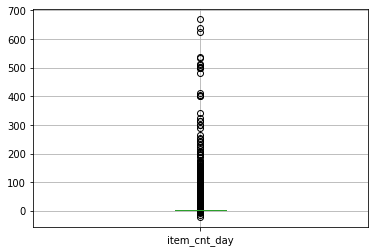

In [13]:
sales_train.boxplot(column=['item_cnt_day'])

# Items Data Prep. & Feature Engineering

In [14]:
pd.options.display.max_rows = 1000
item_categories.head(100)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [15]:
# merge items and item_categories data set on 'item_category_id' to begin crafting
# complete data set
items = pd.merge(items, item_categories, on='item_category_id')
items.head()

,item_name,item_id,item_category_id,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD


In [16]:
# generate a feature called 'genre' to categorize into categories and subcategories
items['genre'] = items['item_category_name'].apply(lambda x: x.split('-')[0])
items.head()

,item_name,item_id,item_category_id,item_category_name,genre
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Кино
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Кино
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Кино
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Кино
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Кино


In [17]:
# adjust some anomolies in the dataset and re-perform feature computation
manual_genre_edit = {
            'Чистые носители (штучные)': 'Чистые носители',
            'Чистые носители (шпиль)' : 'Чистые носители', #Blank Media
            'PC ': 'Аксессуары', ## PC -> Accessories
            'Служебные': 'Служебные ' #Service
            }


items['genre'] = items['genre'].apply(lambda x: manual_genre_edit[x] if x in manual_genre_edit.keys() else x)

In [18]:
# OneHotEncoding - take categories and convert them to numerical data
items['genre_id'] = LabelEncoder().fit_transform(items['genre'])
items.head()

,item_name,item_id,item_category_id,item_category_name,genre,genre_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Кино,11
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Кино,11
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Кино,11
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Кино,11
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Кино,11


In [19]:
items = items[['item_id', 'item_category_id', 'genre_id']]
items.head()

,item_id,item_category_id,genre_id
0,0,40,11
1,2,40,11
2,3,40,11
3,4,40,11
4,5,40,11


In [20]:
print(shops)

                                          shop_name  shop_id
0                     !Якутск Орджоникидзе, 56 фран        0
1                     !Якутск ТЦ "Центральный" фран        1
2                                  Адыгея ТЦ "Мега"        2
3                    Балашиха ТРК "Октябрь-Киномир"        3
4                          Волжский ТЦ "Волга Молл"        4
5                            Вологда ТРЦ "Мармелад"        5
6                        Воронеж (Плехановская, 13)        6
7                            Воронеж ТРЦ "Максимир"        7
8                      Воронеж ТРЦ Сити-Парк "Град"        8
9                                 Выездная Торговля        9
10                       Жуковский ул. Чкалова 39м?       10
11                       Жуковский ул. Чкалова 39м²       11
12                              Интернет-магазин ЧС       12
13                              Казань ТЦ "Бехетле"       13
14                          Казань ТЦ "ПаркХаус" II       14
15                      

In [21]:
# correct duplicate shops - access a group of rows and columns by labels
sales_train.loc[sales_train.shop_id == 57, 'shop_id'] = 0
sales_train.loc[sales_train.shop_id == 58, 'shop_id'] = 1
sales_train.loc[sales_train.shop_id == 11, 'shop_id'] = 10
sales_train.loc[sales_train.shop_id == 39, 'shop_id'] = 40

test.loc[test.shop_id == 57, 'shop_id'] = 0
test.loc[test.shop_id == 58, 'shop_id'] = 1
test.loc[test.shop_id == 11, 'shop_id'] = 10
test.loc[test.shop_id == 39, 'shop_id'] = 40

# check the amount of unique shops and compare number of unique entires in sales_train dataset
rows = len(sales_train)
unique_test_shop_id = test['shop_id'].unique()
sales_train = sales_train[sales_train['shop_id'].isin(unique_test_shop_id)]
print(rows - len(sales_train))

502311


In [22]:
# begin adding sales train info
# we want to aggregate all the sales count by month instead of days so that we can view trends in the dataset

# 'date_block_num','shop_id','item_id' provides a unique primary key to access each tuple in the data set.
aggregate_count = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
aggregate_count.columns = ['item_cnt_month']
aggregate_count.reset_index(inplace=True)

aggregate_count.head()    

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [23]:
#aggregate_days_sold = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['count']})
#aggregate_days_sold.columns = ['days_sold']
#aggregate_days_sold.reset_index(inplace=True)
#aggregate_days_sold.head() 

#cc = aggregate_days_sold.loc[aggregate_days_sold['days_sold'] > 31]
#cc.head()

In [24]:
# now that we have the total monthly sales, we want to determine average price per month

aggregate_price = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_price': ['mean']})
aggregate_price.columns = ['mean_price']
aggregate_price.reset_index(inplace=True)

aggregate_price.head()

,date_block_num,shop_id,item_id,mean_price
0,0,0,32,221.0
1,0,0,33,347.0
2,0,0,35,247.0
3,0,0,43,221.0
4,0,0,51,128.5


In [25]:
# we will now perform left join on the data set so that we can combine the two metrics we computed above
merged = aggregate_count.merge(aggregate_price, on=['date_block_num','shop_id','item_id'], how='left')
merged.head()

,date_block_num,shop_id,item_id,item_cnt_month,mean_price
0,0,0,32,6.0,221.0
1,0,0,33,3.0,347.0
2,0,0,35,1.0,247.0
3,0,0,43,1.0,221.0
4,0,0,51,2.0,128.5


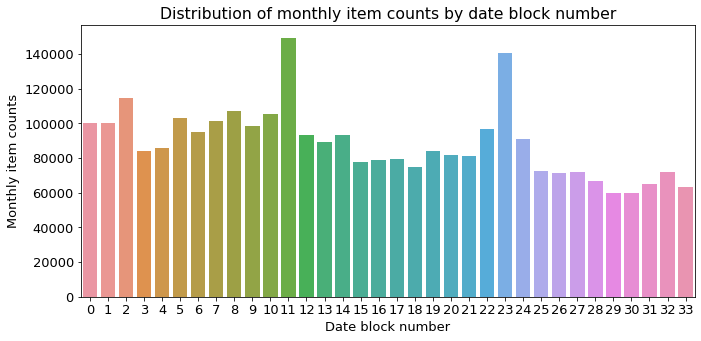

In [26]:
# plot item counts against each month (0-33 months)
# we can see how months 11 + 23 (December) show a spike in sales

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=13)
figure, ax = plt.subplots() 
figure.set_size_inches(11, 5)

# total montly item sales
# group by date, provide sum of item count
group_month_sum = merged.groupby('date_block_num').agg({'item_cnt_month': 'sum'})
group_month_sum = group_month_sum.reset_index()

sns.barplot(x='date_block_num', y='item_cnt_month', data=group_month_sum)
ax.set(title='Distribution of monthly item counts by date block number',
       xlabel='Date block number', 
       ylabel='Monthly item counts');

In [27]:
# append to test data set & set data types
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
# concatenate current dataset and test dataset
merged = pd.concat([merged, test], ignore_index=True, sort=False, keys=['date_block_num','shop_id','item_id'])
merged.fillna(0, inplace=True)


In [28]:
mx = merged.loc[merged['date_block_num'] == 34]
print(len(mx))
mx.head()
print(len(test))


214200
214200


In [29]:
# now, include the items dataset and merge on item id
merged2 = merged.merge(items, on=['item_id'], how='left')
merged2.head()

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id
0,0,0,32,6.0,221.0,0.0,40,11
1,0,0,33,3.0,347.0,0.0,37,11
2,0,0,35,1.0,247.0,0.0,40,11
3,0,0,43,1.0,221.0,0.0,40,11
4,0,0,51,2.0,128.5,0.0,57,13


In [30]:
# normalize month into 1-12 format instead of 0-33
merged2["month_id"] = merged2['date_block_num'].apply(lambda dbn: 1 + dbn % 12)
merged2.head()

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,month_id
0,0,0,32,6.0,221.0,0.0,40,11,1
1,0,0,33,3.0,347.0,0.0,37,11,1
2,0,0,35,1.0,247.0,0.0,40,11,1
3,0,0,43,1.0,221.0,0.0,40,11,1
4,0,0,51,2.0,128.5,0.0,57,13,1


In [31]:
# select may, for example, and let's now inspect for trends during the days of the month
month_inspection = sales_train.loc[sales_train["date_block_num"] == 5]
month_inspection = month_inspection.groupby(['date']).agg({'item_cnt_day': ['sum']})
month_inspection = month_inspection.reset_index()

month_inspection["date"] = month_inspection['date'].apply(lambda x: int(x.split('.')[0]) )
month_inspection.head(5)

,date,item_cnt_day
,,sum
0,1,4823.0
1,2,3663.0
2,3,2733.0
3,4,2753.0
4,5,2892.0


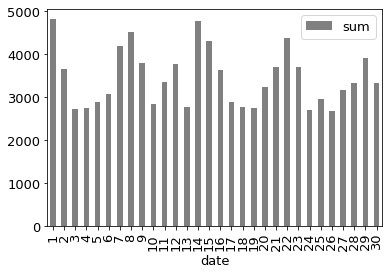

In [32]:
# here, we are able to see that weekends correlate with more sales.
month_inspection.plot.bar(x="date", y="item_cnt_day", color='grey');

In [33]:
# given a month, compute the number of weekends so that we can use as an additional feature
def count_days(date_block_num):
    year = 2013 + date_block_num // 12
    month = 1 + date_block_num % 12
    weeknd_count = len([1 for i in calendar.monthcalendar(year, month) if i[6] != 0])
    return weeknd_count
map_dict = {i: count_days(i) for i in range(35)}

merged2['weeknd_count'] = merged2['date_block_num'].apply(lambda x: map_dict[x])
merged2.head()

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,month_id,weeknd_count
0,0,0,32,6.0,221.0,0.0,40,11,1,4
1,0,0,33,3.0,347.0,0.0,37,11,1,4
2,0,0,35,1.0,247.0,0.0,40,11,1,4
3,0,0,43,1.0,221.0,0.0,40,11,1,4
4,0,0,51,2.0,128.5,0.0,57,13,1,4


In [34]:
# lagging is a critical feature for our training process.
# it allows for model to look back in time and see how the shop performed in the months before.
# currently, we are looking up to 3 months back
def lag_feature(df, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in [1, 2, 3]:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)] = df[col+'_lag_'+str(i)].astype('float16')
    del tmp
    return df

In [35]:
merged2 = lag_feature(merged2, 'item_cnt_month')
merged2[['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3']] = merged2[['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3']].fillna(value=0)

In [36]:
# let's take a look here and now we can see we have counts for the number of items sold
# 1 month before, 2 months before, and 3.
merged2.head(500000)

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,month_id,weeknd_count,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
0,0,0,32,6.0,221.0,0.0,40,11,1,4,0.0,0.0,0.0
1,0,0,33,3.0,347.0,0.0,37,11,1,4,0.0,0.0,0.0
2,0,0,35,1.0,247.0,0.0,40,11,1,4,0.0,0.0,0.0
3,0,0,43,1.0,221.0,0.0,40,11,1,4,0.0,0.0,0.0
4,0,0,51,2.0,128.5,0.0,57,13,1,4,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,11,4,7956,2.0,4990.0,0.0,6,1,12,5,1.0,1.0,0.0
499996,11,4,7961,1.0,2290.0,0.0,6,1,12,5,0.0,0.0,0.0
499997,11,4,7965,1.0,1899.0,0.0,33,9,12,5,3.0,2.0,0.0
499998,11,4,7976,1.0,1299.0,0.0,33,9,12,5,1.0,0.0,0.0


In [37]:

y = merged2.loc[ (merged2['date_block_num'] == 0) & (merged2['shop_id'] == 13) & (merged2['item_id'] == 32)]
y.head()

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,month_id,weeknd_count,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3


In [38]:
##Add target encoding for item/shop for last 3 months 
##item_id_target_mean = merged2.groupby(['date_block_num','item_id', 'shop_id'])['item_cnt_month'].mean().reset_index().rename(columns={
    ##"item_cnt_month": "item_shop_target_enc"}, errors="raise")

##merged2 = pd.merge(merged2, item_id_target_mean, on=['date_block_num','item_id', 'shop_id'], how='left')

##merged2.head()

In [39]:
#xm = merged2.loc[merged2['item_cnt_month'] != merged2['item_shop_target_enc']]
#xm.head()


In [40]:
df2 = merged2.loc[merged2['date_block_num'] == 34]
df2.head()


,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,month_id,weeknd_count,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
1333650,34,5,5037,0.0,0.0,0.0,19,5,11,5,0.0,1.0,3.0
1333651,34,5,5320,0.0,0.0,1.0,55,13,11,5,0.0,0.0,0.0
1333652,34,5,5233,0.0,0.0,2.0,19,5,11,5,1.0,3.0,1.0
1333653,34,5,5232,0.0,0.0,3.0,23,5,11,5,0.0,0.0,1.0
1333654,34,5,5268,0.0,0.0,4.0,20,5,11,5,0.0,0.0,0.0


In [41]:
# create final dataset
# split data into training validation and testing
# we originally put them all together to make feature engineering easier
df = merged2
X_train = df[(df.date_block_num >= 3) & (df.date_block_num < 33)].drop(['item_cnt_month'], axis=1)
Y_train = df[(df.date_block_num >= 3) & (df.date_block_num < 33)]['item_cnt_month']

X_valid = df[df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = df[df.date_block_num == 33]['item_cnt_month']

X_test = df[df.date_block_num == 34]

In [51]:
X_train.head(10)

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,month_id,weeknd_count,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
144832,3,0,30,3.0,399.0,0.0,40,11,4,4,24.0,31.0,0.0
144833,3,0,31,1.0,699.0,0.0,37,11,4,4,10.0,11.0,0.0
144834,3,0,32,6.0,349.0,0.0,40,11,4,4,12.0,10.0,6.0
144835,3,0,34,2.0,149.0,0.0,40,11,4,4,0.0,0.0,0.0
144836,3,0,37,4.0,149.0,0.0,40,11,4,4,0.0,0.0,0.0
144837,3,0,44,2.0,249.0,0.0,57,13,4,4,0.0,0.0,0.0
144838,3,0,46,1.0,249.0,0.0,57,13,4,4,0.0,0.0,0.0
144839,3,0,82,1.0,299.0,0.0,37,11,4,4,0.0,0.0,0.0
144840,3,0,111,1.0,199.0,0.0,57,13,4,4,1.0,1.0,1.0
144841,3,0,113,1.0,199.0,0.0,57,13,4,4,0.0,0.0,0.0


In [42]:
# begin training using lgb
feature_name = X_train.columns.tolist()

params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 2 ** 7 - 1,
    'learning_rate': 0.005,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1
}

feature_name_indexes = [ 
                        'item_category_id',
                        'genre_id',
]

lgb_train = lgb.Dataset(X_train[feature_name], Y_train)
lgb_eval = lgb.Dataset(X_valid[feature_name], Y_valid, reference=lgb_train)

evals_result = {}
gbm = lgb.train(
        params, 
        lgb_train, # data to be trained on
        num_boost_round=10000, # boosting iterations
        valid_sets=(lgb_train, lgb_eval), # data to be evaluted on
        feature_name = feature_name, # define numerical features
        categorical_feature = feature_name_indexes, # define categorical features
        verbose_eval=5, #print eval metric on every boosting iteration
        evals_result = evals_result, # where to store eval results
        ##early_stopping_rounds = 500
)

/home/aj/.local/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['genre_id', 'item_category_id']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1204
[LightGBM] [Info] Number of data points in the train set: 1158064, number of used features: 12
[LightGBM] [Info] Start training from score 2.273285


/home/aj/.local/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/aj/.local/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[5]	training's rmse: 8.69749	valid_1's rmse: 6.63547
[10]	training's rmse: 8.52389	valid_1's rmse: 6.48608
[15]	training's rmse: 8.3193	valid_1's rmse: 6.32923
[20]	training's rmse: 8.13752	valid_1's rmse: 6.17333
[25]	training's rmse: 7.94079	valid_1's rmse: 6.01808
[30]	training's rmse: 7.79697	valid_1's rmse: 5.88739
[35]	training's rmse: 7.62396	valid_1's rmse: 5.74873
[40]	training's rmse: 7.47023	valid_1's rmse: 5.61546
[45]	training's rmse: 7.30327	valid_1's rmse: 5.48727
[50]	training's rmse: 7.1469	valid_1's rmse: 5.36179
[55]	training's rmse: 6.99313	valid_1's rmse: 5.22913
[60]	training's rmse: 6.82548	valid_1's rmse: 5.09636
[65]	training's rmse: 6.68452	valid_1's rmse: 4.97796
[70]	training's rmse: 6.52634	valid_1's rmse: 4.85226
[75]	training's rmse: 6.38592	valid_1's rmse: 4.73624
[80]	training's rmse: 6.24557	valid_1's rmse: 4.62383
[85]	training's rmse: 6.09957	valid_1's rmse: 4.50979
[90]	training's rmse: 5.95968	valid_1's rmse: 4.40122
[95]	training's rmse: 5.83247	v

[755]	training's rmse: 1.43107	valid_1's rmse: 0.714735
[760]	training's rmse: 1.42859	valid_1's rmse: 0.717453
[765]	training's rmse: 1.42536	valid_1's rmse: 0.71498
[770]	training's rmse: 1.42175	valid_1's rmse: 0.711007
[775]	training's rmse: 1.41811	valid_1's rmse: 0.707763
[780]	training's rmse: 1.41572	valid_1's rmse: 0.705773
[785]	training's rmse: 1.41202	valid_1's rmse: 0.702601
[790]	training's rmse: 1.40871	valid_1's rmse: 0.699992
[795]	training's rmse: 1.40532	valid_1's rmse: 0.697058
[800]	training's rmse: 1.40258	valid_1's rmse: 0.693897
[805]	training's rmse: 1.39942	valid_1's rmse: 0.690325
[810]	training's rmse: 1.39663	valid_1's rmse: 0.687521
[815]	training's rmse: 1.39351	valid_1's rmse: 0.684436
[820]	training's rmse: 1.39134	valid_1's rmse: 0.681299
[825]	training's rmse: 1.38657	valid_1's rmse: 0.675353
[830]	training's rmse: 1.38415	valid_1's rmse: 0.676579
[835]	training's rmse: 1.38167	valid_1's rmse: 0.673714
[840]	training's rmse: 1.37967	valid_1's rmse: 0.

[1485]	training's rmse: 1.19173	valid_1's rmse: 0.519143
[1490]	training's rmse: 1.19162	valid_1's rmse: 0.518752
[1495]	training's rmse: 1.19038	valid_1's rmse: 0.518001
[1500]	training's rmse: 1.18865	valid_1's rmse: 0.516951
[1505]	training's rmse: 1.18797	valid_1's rmse: 0.516884
[1510]	training's rmse: 1.1872	valid_1's rmse: 0.516402
[1515]	training's rmse: 1.18632	valid_1's rmse: 0.515843
[1520]	training's rmse: 1.18592	valid_1's rmse: 0.515703
[1525]	training's rmse: 1.1853	valid_1's rmse: 0.515144
[1530]	training's rmse: 1.18412	valid_1's rmse: 0.515112
[1535]	training's rmse: 1.1836	valid_1's rmse: 0.514458
[1540]	training's rmse: 1.18343	valid_1's rmse: 0.513625
[1545]	training's rmse: 1.1827	valid_1's rmse: 0.513586
[1550]	training's rmse: 1.18206	valid_1's rmse: 0.513622
[1555]	training's rmse: 1.1815	valid_1's rmse: 0.513436
[1560]	training's rmse: 1.181	valid_1's rmse: 0.5133
[1565]	training's rmse: 1.18049	valid_1's rmse: 0.512735
[1570]	training's rmse: 1.17993	valid_1'

[2210]	training's rmse: 1.11625	valid_1's rmse: 0.482571
[2215]	training's rmse: 1.11517	valid_1's rmse: 0.482306
[2220]	training's rmse: 1.11502	valid_1's rmse: 0.481889
[2225]	training's rmse: 1.11463	valid_1's rmse: 0.481853
[2230]	training's rmse: 1.11421	valid_1's rmse: 0.482487
[2235]	training's rmse: 1.11382	valid_1's rmse: 0.482666
[2240]	training's rmse: 1.11371	valid_1's rmse: 0.48282
[2245]	training's rmse: 1.11331	valid_1's rmse: 0.48273
[2250]	training's rmse: 1.11312	valid_1's rmse: 0.481914
[2255]	training's rmse: 1.11268	valid_1's rmse: 0.481627
[2260]	training's rmse: 1.11248	valid_1's rmse: 0.4818
[2265]	training's rmse: 1.11216	valid_1's rmse: 0.482334
[2270]	training's rmse: 1.11209	valid_1's rmse: 0.482555
[2275]	training's rmse: 1.11162	valid_1's rmse: 0.482127
[2280]	training's rmse: 1.1111	valid_1's rmse: 0.482548
[2285]	training's rmse: 1.11102	valid_1's rmse: 0.482138
[2290]	training's rmse: 1.11087	valid_1's rmse: 0.48202
[2295]	training's rmse: 1.11	valid_1'

[2940]	training's rmse: 1.04205	valid_1's rmse: 0.469568
[2945]	training's rmse: 1.04136	valid_1's rmse: 0.470137
[2950]	training's rmse: 1.04083	valid_1's rmse: 0.4701
[2955]	training's rmse: 1.04044	valid_1's rmse: 0.46986
[2960]	training's rmse: 1.03992	valid_1's rmse: 0.468858
[2965]	training's rmse: 1.03982	valid_1's rmse: 0.468697
[2970]	training's rmse: 1.03948	valid_1's rmse: 0.468604
[2975]	training's rmse: 1.0394	valid_1's rmse: 0.468532
[2980]	training's rmse: 1.0391	valid_1's rmse: 0.469105
[2985]	training's rmse: 1.0381	valid_1's rmse: 0.468872
[2990]	training's rmse: 1.03795	valid_1's rmse: 0.468679
[2995]	training's rmse: 1.03772	valid_1's rmse: 0.468521
[3000]	training's rmse: 1.03709	valid_1's rmse: 0.468562
[3005]	training's rmse: 1.03681	valid_1's rmse: 0.468295
[3010]	training's rmse: 1.03644	valid_1's rmse: 0.468099
[3015]	training's rmse: 1.03629	valid_1's rmse: 0.467183
[3020]	training's rmse: 1.03609	valid_1's rmse: 0.466792
[3025]	training's rmse: 1.03584	valid

[3665]	training's rmse: 0.994825	valid_1's rmse: 0.471787
[3670]	training's rmse: 0.994644	valid_1's rmse: 0.471689
[3675]	training's rmse: 0.99428	valid_1's rmse: 0.471779
[3680]	training's rmse: 0.993774	valid_1's rmse: 0.471876
[3685]	training's rmse: 0.99356	valid_1's rmse: 0.471998
[3690]	training's rmse: 0.993315	valid_1's rmse: 0.471938
[3695]	training's rmse: 0.992519	valid_1's rmse: 0.471411
[3700]	training's rmse: 0.992413	valid_1's rmse: 0.471187
[3705]	training's rmse: 0.992139	valid_1's rmse: 0.471511
[3710]	training's rmse: 0.991491	valid_1's rmse: 0.471801
[3715]	training's rmse: 0.990651	valid_1's rmse: 0.471127
[3720]	training's rmse: 0.990071	valid_1's rmse: 0.470804
[3725]	training's rmse: 0.99003	valid_1's rmse: 0.471031
[3730]	training's rmse: 0.989946	valid_1's rmse: 0.470705
[3735]	training's rmse: 0.989664	valid_1's rmse: 0.470918
[3740]	training's rmse: 0.989587	valid_1's rmse: 0.471259
[3745]	training's rmse: 0.989079	valid_1's rmse: 0.471491
[3750]	training's

[4380]	training's rmse: 0.944788	valid_1's rmse: 0.470731
[4385]	training's rmse: 0.94433	valid_1's rmse: 0.470985
[4390]	training's rmse: 0.944229	valid_1's rmse: 0.471088
[4395]	training's rmse: 0.943813	valid_1's rmse: 0.47097
[4400]	training's rmse: 0.943331	valid_1's rmse: 0.471092
[4405]	training's rmse: 0.942781	valid_1's rmse: 0.470188
[4410]	training's rmse: 0.942445	valid_1's rmse: 0.470697
[4415]	training's rmse: 0.942287	valid_1's rmse: 0.470744
[4420]	training's rmse: 0.942209	valid_1's rmse: 0.470594
[4425]	training's rmse: 0.941859	valid_1's rmse: 0.470666
[4430]	training's rmse: 0.941719	valid_1's rmse: 0.470713
[4435]	training's rmse: 0.941452	valid_1's rmse: 0.470856
[4440]	training's rmse: 0.941359	valid_1's rmse: 0.470522
[4445]	training's rmse: 0.941301	valid_1's rmse: 0.470512
[4450]	training's rmse: 0.941167	valid_1's rmse: 0.470423
[4455]	training's rmse: 0.940763	valid_1's rmse: 0.472962
[4460]	training's rmse: 0.940528	valid_1's rmse: 0.47298
[4465]	training's

[5090]	training's rmse: 0.904441	valid_1's rmse: 0.463172
[5095]	training's rmse: 0.904336	valid_1's rmse: 0.463193
[5100]	training's rmse: 0.90421	valid_1's rmse: 0.463384
[5105]	training's rmse: 0.904099	valid_1's rmse: 0.463489
[5110]	training's rmse: 0.904004	valid_1's rmse: 0.463207
[5115]	training's rmse: 0.903942	valid_1's rmse: 0.463105
[5120]	training's rmse: 0.903673	valid_1's rmse: 0.462992
[5125]	training's rmse: 0.903477	valid_1's rmse: 0.4632
[5130]	training's rmse: 0.903245	valid_1's rmse: 0.46306
[5135]	training's rmse: 0.902689	valid_1's rmse: 0.463486
[5140]	training's rmse: 0.902557	valid_1's rmse: 0.463454
[5145]	training's rmse: 0.902457	valid_1's rmse: 0.463133
[5150]	training's rmse: 0.902203	valid_1's rmse: 0.46299
[5155]	training's rmse: 0.90183	valid_1's rmse: 0.463196
[5160]	training's rmse: 0.901543	valid_1's rmse: 0.462922
[5165]	training's rmse: 0.901384	valid_1's rmse: 0.462704
[5170]	training's rmse: 0.901137	valid_1's rmse: 0.462307
[5175]	training's rm

[5800]	training's rmse: 0.863922	valid_1's rmse: 0.467858
[5805]	training's rmse: 0.863819	valid_1's rmse: 0.467937
[5810]	training's rmse: 0.86359	valid_1's rmse: 0.46796
[5815]	training's rmse: 0.86325	valid_1's rmse: 0.467962
[5820]	training's rmse: 0.863162	valid_1's rmse: 0.467736
[5825]	training's rmse: 0.862266	valid_1's rmse: 0.467279
[5830]	training's rmse: 0.85894	valid_1's rmse: 0.466755
[5835]	training's rmse: 0.858782	valid_1's rmse: 0.466683
[5840]	training's rmse: 0.858627	valid_1's rmse: 0.466988
[5845]	training's rmse: 0.858374	valid_1's rmse: 0.466857
[5850]	training's rmse: 0.858251	valid_1's rmse: 0.467165
[5855]	training's rmse: 0.85816	valid_1's rmse: 0.467428
[5860]	training's rmse: 0.857543	valid_1's rmse: 0.467135
[5865]	training's rmse: 0.857343	valid_1's rmse: 0.467123
[5870]	training's rmse: 0.857128	valid_1's rmse: 0.466913
[5875]	training's rmse: 0.857144	valid_1's rmse: 0.467034
[5880]	training's rmse: 0.856964	valid_1's rmse: 0.466876
[5885]	training's r

[6520]	training's rmse: 0.826333	valid_1's rmse: 0.471658
[6525]	training's rmse: 0.826241	valid_1's rmse: 0.471909
[6530]	training's rmse: 0.826133	valid_1's rmse: 0.472161
[6535]	training's rmse: 0.825983	valid_1's rmse: 0.472098
[6540]	training's rmse: 0.825863	valid_1's rmse: 0.472238
[6545]	training's rmse: 0.825186	valid_1's rmse: 0.472674
[6550]	training's rmse: 0.825026	valid_1's rmse: 0.472795
[6555]	training's rmse: 0.824774	valid_1's rmse: 0.47277
[6560]	training's rmse: 0.824523	valid_1's rmse: 0.472422
[6565]	training's rmse: 0.824255	valid_1's rmse: 0.472129
[6570]	training's rmse: 0.824064	valid_1's rmse: 0.471965
[6575]	training's rmse: 0.823851	valid_1's rmse: 0.471989
[6580]	training's rmse: 0.823571	valid_1's rmse: 0.471779
[6585]	training's rmse: 0.823455	valid_1's rmse: 0.471618
[6590]	training's rmse: 0.823447	valid_1's rmse: 0.471449
[6595]	training's rmse: 0.823284	valid_1's rmse: 0.47182
[6600]	training's rmse: 0.822904	valid_1's rmse: 0.472333
[6605]	training'

[7235]	training's rmse: 0.792926	valid_1's rmse: 0.476028
[7240]	training's rmse: 0.792657	valid_1's rmse: 0.47572
[7245]	training's rmse: 0.792644	valid_1's rmse: 0.475799
[7250]	training's rmse: 0.792621	valid_1's rmse: 0.475498
[7255]	training's rmse: 0.79222	valid_1's rmse: 0.475352
[7260]	training's rmse: 0.791875	valid_1's rmse: 0.47546
[7265]	training's rmse: 0.791793	valid_1's rmse: 0.4755
[7270]	training's rmse: 0.791722	valid_1's rmse: 0.475447
[7275]	training's rmse: 0.791335	valid_1's rmse: 0.475312
[7280]	training's rmse: 0.791128	valid_1's rmse: 0.475361
[7285]	training's rmse: 0.791151	valid_1's rmse: 0.47526
[7290]	training's rmse: 0.791025	valid_1's rmse: 0.475071
[7295]	training's rmse: 0.790873	valid_1's rmse: 0.474478
[7300]	training's rmse: 0.790657	valid_1's rmse: 0.47381
[7305]	training's rmse: 0.790341	valid_1's rmse: 0.473652
[7310]	training's rmse: 0.790226	valid_1's rmse: 0.473818
[7315]	training's rmse: 0.790233	valid_1's rmse: 0.47351
[7320]	training's rmse

[7945]	training's rmse: 0.764351	valid_1's rmse: 0.474854
[7950]	training's rmse: 0.764259	valid_1's rmse: 0.474613
[7955]	training's rmse: 0.764117	valid_1's rmse: 0.474676
[7960]	training's rmse: 0.764078	valid_1's rmse: 0.474916
[7965]	training's rmse: 0.763653	valid_1's rmse: 0.476162
[7970]	training's rmse: 0.763442	valid_1's rmse: 0.476164
[7975]	training's rmse: 0.763156	valid_1's rmse: 0.475843
[7980]	training's rmse: 0.763078	valid_1's rmse: 0.476038
[7985]	training's rmse: 0.762968	valid_1's rmse: 0.476081
[7990]	training's rmse: 0.762864	valid_1's rmse: 0.476067
[7995]	training's rmse: 0.762847	valid_1's rmse: 0.476103
[8000]	training's rmse: 0.762747	valid_1's rmse: 0.475986
[8005]	training's rmse: 0.76267	valid_1's rmse: 0.476079
[8010]	training's rmse: 0.762191	valid_1's rmse: 0.474335
[8015]	training's rmse: 0.762182	valid_1's rmse: 0.474277
[8020]	training's rmse: 0.761768	valid_1's rmse: 0.474416
[8025]	training's rmse: 0.761524	valid_1's rmse: 0.47473
[8030]	training'

[8655]	training's rmse: 0.734173	valid_1's rmse: 0.478823
[8660]	training's rmse: 0.733955	valid_1's rmse: 0.478273
[8665]	training's rmse: 0.733904	valid_1's rmse: 0.478066
[8670]	training's rmse: 0.733682	valid_1's rmse: 0.478099
[8675]	training's rmse: 0.733676	valid_1's rmse: 0.47815
[8680]	training's rmse: 0.733474	valid_1's rmse: 0.478564
[8685]	training's rmse: 0.733428	valid_1's rmse: 0.478474
[8690]	training's rmse: 0.733405	valid_1's rmse: 0.478699
[8695]	training's rmse: 0.733208	valid_1's rmse: 0.478399
[8700]	training's rmse: 0.733084	valid_1's rmse: 0.478109
[8705]	training's rmse: 0.732922	valid_1's rmse: 0.477952
[8710]	training's rmse: 0.732826	valid_1's rmse: 0.478009
[8715]	training's rmse: 0.73277	valid_1's rmse: 0.477696
[8720]	training's rmse: 0.732498	valid_1's rmse: 0.477817
[8725]	training's rmse: 0.732355	valid_1's rmse: 0.477795
[8730]	training's rmse: 0.732307	valid_1's rmse: 0.477547
[8735]	training's rmse: 0.73225	valid_1's rmse: 0.477681
[8740]	training's

[9370]	training's rmse: 0.712059	valid_1's rmse: 0.475955
[9375]	training's rmse: 0.711923	valid_1's rmse: 0.476396
[9380]	training's rmse: 0.711826	valid_1's rmse: 0.476251
[9385]	training's rmse: 0.711686	valid_1's rmse: 0.476347
[9390]	training's rmse: 0.71123	valid_1's rmse: 0.476502
[9395]	training's rmse: 0.711204	valid_1's rmse: 0.47632
[9400]	training's rmse: 0.711063	valid_1's rmse: 0.476239
[9405]	training's rmse: 0.710934	valid_1's rmse: 0.476164
[9410]	training's rmse: 0.710843	valid_1's rmse: 0.476145
[9415]	training's rmse: 0.710689	valid_1's rmse: 0.476474
[9420]	training's rmse: 0.710276	valid_1's rmse: 0.476242
[9425]	training's rmse: 0.710227	valid_1's rmse: 0.476289
[9430]	training's rmse: 0.710194	valid_1's rmse: 0.476069
[9435]	training's rmse: 0.710118	valid_1's rmse: 0.47599
[9440]	training's rmse: 0.710028	valid_1's rmse: 0.475803
[9445]	training's rmse: 0.709972	valid_1's rmse: 0.475951
[9450]	training's rmse: 0.709799	valid_1's rmse: 0.476035
[9455]	training's

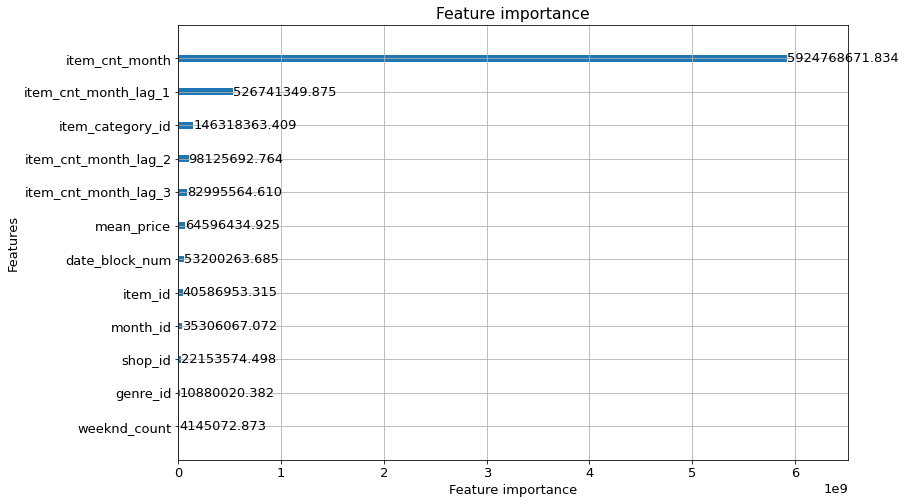

In [45]:
# plot feature significance to training
lgb.plot_importance(
    gbm, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(12,8));

In [50]:
# predict & export submissions
test = pd.read_csv('competitive-data-science-predict-future-sales/test.csv')
Y_test = gbm.predict(X_test[feature_name]).clip(0, 20)



submission = pd.DataFrame({ "ID": test.index, "item_cnt_month": Y_test }) 
submission.to_csv('gbm_submissionXYZZ.csv', index=False)

In [47]:
print(len(Y_test))

NameError: name 'Y_test' is not defined

In [48]:
print(len(test))

214200


In [ ]:
test.head()


In [ ]:
print(Y_test)


In [49]:

print(len(X_test))

214200
